In [9]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [10]:
columns_name=['user_id','item_id','rating']
data=pd.read_csv('test.dat',sep=' ',names=columns_name,encoding='latin-1')

In [11]:
data.head(5)

,user_id,item_id,rating
0,0,0,5.0
1,0,1,4.0
2,0,3,2.0
3,0,4,2.0
4,1,0,5.0


In [12]:
n_users=int(np.max(data.iloc[:,0])+1)
n_items=int(np.max(data.iloc[:,1])+1)
print("Number user:{}".format(n_users))
print("Number item:{}".format(n_items))

Number user:7
Number item:5


<img src='mf.png'>

In [13]:
class MatrixFactorization(object):
    def __init__(self,data,K,lam=0.1,X_init=None,W_init=None,max_iter=10000,learing_rate=0.5,epoch_print=100):
        self.data_raw=data
        self.K=K
        self.lam=lam
        self.max_iter=max_iter
        self.learing_rate=learing_rate
        self.epoch_print=epoch_print
        self.n_users=int(np.max(data[:,0]))+1
        self.m_items=int(np.max(data[:,1]))+1
        
        if X_init is None:
            self.X=np.random.rand(self.m_items,K)
        else:
            self.X=X_init
            
        if W_init is None:
            self.W=np.random.rand(K,self.n_users)
        else :
            self.W=W_init
        self.n_ratings=self.data_raw.shape[0]
        self.data=self.data_raw.copy()
    
    def normalize_rating(self):
        users=self.data[:,0]
        self.mean_userid_rating=np.zeros((self.n_users,))
        for i in range(self.n_users):
            ids=np.where(users==i)[0].astype(np.int32)
            ratings=self.data[ids,2]
            mean=np.mean(ratings)
            if np.isnan(mean):
                mean=0
            self.mean_userid_rating[i]=mean
            self.data[ids,2]=ratings-mean
    
    def get_user_rated_for_item(self,item_id):
        ids=np.where(self.data[:,1]==item_id)[0]
        users_id=self.data[ids,0].astype(np.int32)
        ratings=self.data[ids,2].astype(np.int32)
        return (users_id,ratings)
    
    def updateX(self):
        for m in range(self.m_items):
            userids,ratings=self.get_user_rated_for_item(m)
            Wm=self.W[:,userids]
            
            grad_X=-(ratings-self.X[m,:].dot(Wm)).dot(Wm.T)+self.lam*self.X[m,:]
            self.X[m,:]-=self.learing_rate*grad_X.reshape((self.K,))
            
    def get_item_rated_from_user(self,user_id):
        ids=np.where(self.data[:,0]==user_id)[0]
        ratings=self.data[ids,2].astype(np.int32)
        items_id=self.data[ids,1].astype(np.int32)
        return (items_id,ratings)
        
    def updateW(self):
        for m in range(self.n_users):
            items_id,ratings=self.get_item_rated_from_user(m)
            Xm=self.X[items_id,:]
            grad_w=-Xm.T.dot(ratings-Xm.dot(self.W[:,m]))/self.n_ratings+self.lam*self.W[:,m]
            self.W[:,m]-=self.learing_rate*grad_w.reshape((self.K,))
            
            
    def loss(self):
        loss_value=0
        for i in range(self.data.shape[0]):
            n,m,rate_score=int(self.data[i,0]),int(self.data[i,1]),float(self.data[i,2])
            loss_value+=0.5*(rate_score-self.X[m,:].dot(self.W[:,n]))**2
        loss_value=loss_value/self.n_ratings+0.5*self.lam*(np.linalg.norm(self.X)+np.linalg.norm(self.W))
        return loss_value
    
    def pred(self,user_id,item_id):
        mean_score=self.mean_userid_rating[user_id]
        predict_score=self.X[item_id,:].dot(self.W[:,user_id])+mean_score
        if predict_score>5:
            predict_score=5
        elif predict_score<0:
            predict_score=0
        return predict_score
        
        
    def evaluate_RMSE(self):
        SE=0
        for i in range(self.n_ratings):
            predict_rating_score=self.pred(int(self.data[i,0]),int(self.data[i,1]))
            SE+=(self.data_raw[i,2]-predict_rating_score)**2
        
        RMSE= np.sqrt(SE/self.n_ratings)
        return RMSE
            
    def fit(self):
        self.normalize_rating()
        loss_his=[]
        for epoch in range(self.max_iter):
            self.updateX()
            self.updateW()
            loss=self.loss()
            loss_his.append(loss)
            if (epoch+1)%self.epoch_print==0:
                print(" Epoch: {}, loss={}, RMSE={}".format(epoch+1,loss,self.evaluate_RMSE()))
        plt.plot(np.arange(self.max_iter),loss_his)
        plt.show()
        

 Epoch: 1000, loss=0.5617570775746172, RMSE=0.6751645133422802


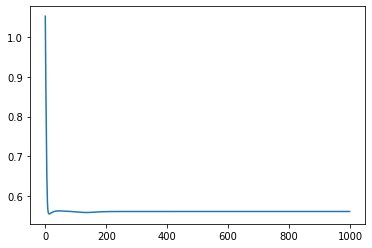

In [14]:
data=data.values
model=MatrixFactorization(data,K=2,max_iter=1000,epoch_print=1000)
model.fit()

In [15]:
score_predict=model.X.dot(model.W)+model.mean_userid_rating
index_list=['item_'+str(i+1) for i in range(n_items)]
column_list=['user_'+str(i+1) for i in range(n_users)]
df=pd.DataFrame(data=score_predict,index=index_list,columns=column_list)

In [16]:
df

,user_1,user_2,user_3,user_4,user_5,user_6,user_7
item_1,4.234127,4.251541,2.078098,0.347025,1.649368,1.5,2.510403
item_2,3.434323,2.589871,2.753570,0.600534,2.218668,1.5,3.752666
item_3,3.459568,3.983860,1.721325,2.258412,2.571561,1.5,1.970384
item_4,2.511415,2.314178,2.295869,2.931718,3.329444,1.5,3.053014
item_5,2.398157,1.093948,3.133716,1.744570,3.137783,1.5,4.508646


# Movielen 100k

In [37]:
dataset=pd.read_csv('../Data/ratings.csv')

In [38]:
dataset=dataset.drop(['index'],axis=1)
dataset['user_id']-=1
dataset['movie_id']-=1

In [40]:
dataset.head(2)

,user_id,movie_id,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109


In [42]:
n_users=int(np.max(dataset.iloc[:,0])+1)
n_items=int(np.max(dataset.iloc[:,1])+1)
print("Number user:{}".format(n_users))
print("Number item:{}".format(n_items))

Number user:6040
Number item:3952


In [ ]:
dataset=dataset.values
model=MatrixFactorization(dataset,K=30,max_iter=10000,epoch_print=100)
model.fit()